# Polynomial Regression, Overfitting, and Regularization

ข้อมูลจำนวนมากที่พบเจอในการทำงานจริง มักมีความสัมพันธ์ที่ซับซ้อน ซึ่งเมื่อนำมา plot ดูแล้วอาจจะมีหน้าตาที่ไม่สอดคล้องกับโมเดลเชิงเส้น ดังตัวอย่างด้านล่าง ที่ $y$ ถูกสร้างมาจากสมการ $y=x^2$

In [1]:
import pdb, sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import ipywidgets as widgets  # ใช้สำหรับการทำ interactive display

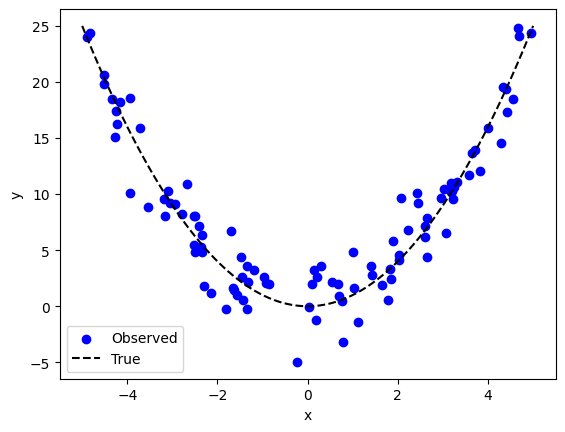

In [2]:
def generate_sample_poly(x, w_list, include_noise=True, noise_level=2):

  # จำลองการใส่สัญญาณรบกวนเข้าไป
  if include_noise:
    noise = noise_level*np.random.randn(*x.shape)
  else:
    noise = 0

  y = 0

  # ค่อย ๆ เติม พจน์ที่มีเลขยกกำลังต่าง ๆ กัน ตาที่กำหนดไว้ใน w_list
  for curr_order, curr_w in enumerate(w_list):
    y += curr_w* (x**curr_order)

  return y + noise


num_samples = 100
w = [0,0,1]
x = 10*np.random.rand(num_samples,1) - 5
y = generate_sample_poly(x, w, include_noise=True)

# สร้างข้อมูลที่ไม่มีสัญญาณรบกวนมาเปรียบเทียบ
y_true = generate_sample_poly(x, w, include_noise=False)

# สร้างข้อมูลที่ไม่มีสัญญาณรบกวนมาแบบละเอียด เพื่อใช้ในการวาดกราฟ (เส้นประสีดำ)
x_whole_line = np.linspace(-5,5,100)
y_true_whole_line = generate_sample_poly(x_whole_line, w, include_noise=False)

# Plot ข้อมูล x, y ที่มีอยู่
fig, ax = plt.subplots()
ax.scatter(x, y, c='b', label='Observed')
ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True' )
ax.set(xlabel='x', ylabel='y')
ax.legend()
plt.show()

หากเรานำเอาสมการเส้นตรง $ y = \hat{w_0} + \hat{w_1} x$ มาอธิบายข้อมูลประเภทนี้ จะส่งผลให้เกิดความคาดเคลื่อนได้

Estimated slope 0.12

Estimated intercept 8.12


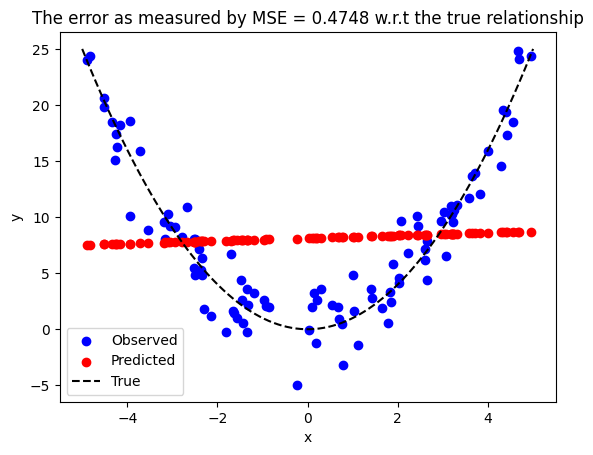

In [3]:
model_linear = LinearRegression()

# ให้โมเดลหาค่า w_0 and w_1 จากข้อมูล (x,y) ทั้งหมดที่มี
model_linear.fit(x, y)

w0_hat = model_linear.intercept_[0]
w1_hat = model_linear.coef_[0][0]


print(f"Estimated slope {w1_hat:0.2f}\n")
print(f"Estimated intercept {w0_hat:0.2f}")

# ใช้โมเดลทำนายค่า y จากค่า x วิธีที่ 2
y_hat = model_linear.predict(x)

# ฟังก์ชันสำหรับวัด mean squared error ระหว่างค่าที่ทำนายได้ (y_hat) และค่าผลเฉลย y
def mse(y, y_hat):
  return np.mean((y-y_hat)**2)/y.shape[0]

mse_val = mse(y_true,y_hat)

# แสดงผลการทำนาย
fig, ax = plt.subplots()
ax.scatter(x, y, c='b', label='Observed')
ax.set(xlabel='x', ylabel='y')
ax.scatter(x, y_hat, c='r', label='Predicted')
ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True' )
ax.legend()
ax.set_title(f"The error as measured by MSE = {mse_val:0.4f} w.r.t the true relationship")
plt.show()


จะพบว่าโมเดลเส้นตรงนั้นไม่สอดคล้องกับข้อมูลที่เรามีอยู่ สังเกตได้จาก

1.   ข้อมูลสีแดงที่โมเดลทำนายมา ไม่สอดคล้องกับข้อมูลจุดสีน้ำเงิน
2.   ค่า mean squared error (MSE) สูง

จึงมีความจำเป็นที่จะต้องหาวิธีที่จะอธิบายความสัมพันธ์แบบที่ไม่เป็นเส้นตรง (nonlinear relationship) ได้

ในส่วนนี้เราจะลองใช้โมเดลที่มีสมการดังนี้ $y = \hat{w_0} + \hat{w_1}x+ \hat{w_2}x^2+ ...+ \hat{w_p} x^p$

*   ถ้า $p = 1$ เราจะได้โมเดล $y = \hat{w_0} + \hat{w_1} x$ ในการพัฒนาโมเดลในกรณีนี้ เราจะต้องหาค่า $\hat{w_0}$ (จุดตัดแกน $y$ ที่เหมาะสม) และค่า $\hat{w_1}$ (ค่าความชันของเส้นตรง) ได้เหมือนกับตัวอย่างที่ผ่าน ๆ มา

*   ถ้า $p = 2$ เราจะได้โมเดล $y = \hat{w_0} + \hat{w_1} x + \hat{w_2} x^2$ ในกรณีนี้เราจะต้องหาค่า $\hat{w_0}, \hat{w_1}$ และ $\hat{w_2}$

*   ถ้า $p = 3$ เราจะได้โมเดล $y = \hat{w_0} + \hat{w_1} x + \hat{w_2} x^2 + \hat{w_3} x^3$ ในกรณีนี้เราจะต้องหาค่า $\hat{w_0}, \hat{w_1}, \hat{w_2}$ และ $\hat{w_3}$

สังเกตได้ว่ายิ่ง $p$ มีค่าสูงมากขึ้น จำนวนตัวแปรที่เราต้องหาค่าเพื่อพัฒนาโมเดลจะเพิ่มขึ้น

หากเราสนใจประมาณค่า $\hat{w}$ โมเดลนี้จะถือว่าเป็นโมเดลเชิงเส้น (ในโมเดลไม่มีพจน์ประเภทที่เลขชี้กำลังของ $\hat{w}$ มีค่าไม่ใช่ $0$ หรือ $1$ เลย เช่น ไม่มี $\hat{w^2}, \hat{w^3}, ..., \hat{w^p}$ เลย) ทำให้เราสามารถใช้ `LinearRegression` ในการแก้ปัญหาได้เหมือนเดิม เพียงแต่เราต้องมีการปรับแก้ input ก่อน

---
ข้อมูลทางเทคนิคเพิ่มเติม

หากกำหนดให้ $z_{(i)} = x^i$ จะส่งผลให้เราสามารถเขียนโมเดลใหม่ได้เป็น
$y = \hat{w_0} + \hat{w_1} z_{(1)}+ \hat{w_2} z_{(2)} + ...+ \hat{w_p} z_{(p)}$ ซึ่งเป็นโมเดลเชิงเส้นนั่นเอง

---

ในส่วนถัดไป เราจะลองนำเอาโมเดล $y = \hat{w_0} + \hat{w_1} z_{(1)}+ \hat{w_2} z_{(2)} + \hat{w_3} z_{(3)} + \hat{w_4} z_{(4)}$ มาใช้กับข้อมูลจากข้อก่อนหน้า

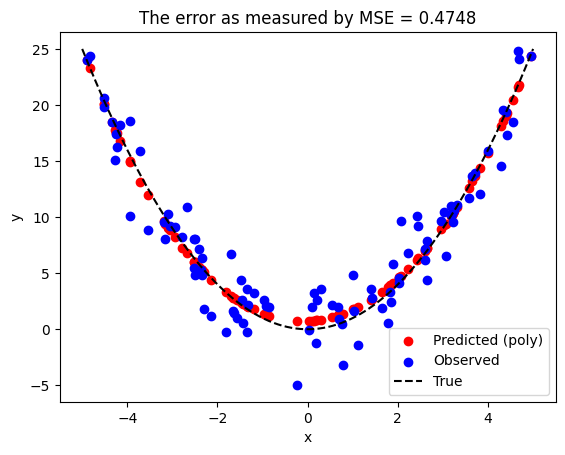

[w_0, w_1, ...]= [ 0.          0.17413679  0.85183539 -0.00832567  0.00486855]


In [4]:
# ฟังก์ชันสำหรับ fit โมเดล polynomial ที่มี order ที่กำหนด และ ทำนายผลของโมเดลหลังจากถูกสอนด้วย training data แล้ว
def fit_and_predict_polynomial(x_train, # ค่า x ที่ใช้เป็น input ของโมเดล (จาก training data)
                               y_train, # ค่า y ที่ใช้เป็นเฉลยให้โมเดล (จาก training data)
                               poly_order=4, # ค่า order ของ polynomial ที่เราใช้
                               x_test_dict=None, # Python dictionary ที่ใช้เก็บชุดข้อมูลที่เราอยากจะนำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้
                               y_test_dict=None): # Python dictionary ที่ใช้เก็บชุดข้อมูลที่ค่า y ที่เป็นเฉลยของข้อมูลที่นำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้

  # สร้างตัวแปรประเภท Python dictionary สำหรับเก็บค่า output ของฟังก์ชันนี้
  mse_dict = {} # ค่า mse
  out_x = {} # ค่า x ที่ใช้เป็น input ของโมเดล
  out_y_hat = {} # ค่า y ที่โมเดลตอบมา
  out_y = {} # ค่า y ที่เป็นเฉลย

  # สร้างโมเดลสำหรับแปลงจาก x เป็น z
  extract_poly_feat = PolynomialFeatures(degree=poly_order, include_bias=True)

  # แปลงจากค่า x ให้กลายเป็น z
  z_train = extract_poly_feat.fit_transform(x_train)

  # สร้างโมเดล y = w_0 + w_1*z_1 + w_2 * z_2 + ...
  model_poly = LinearRegression()

  # สอนโมเดลจาก training data ที่ input ถูก transfrom จาก x มาเป็น z แล้ว
  model_poly.fit(z_train, y_train)

  # ทดสอบโมเดลบน training data
  y_hat_train = model_poly.predict(z_train)

  # ถ้าเกิดว่า user ไม่ได้ให้ test data มา จะใช้ training data เป็น test data
  if x_test_dict is None:
    x_test_dict = {}
    y_test_dict = {}

  # เพิ่ม training data เข้าไปใน test_dict เพื่อที่จะใช้เป็นหนึ่งในข้อมูลสำหรับที่จะให้โมเดลลองทำนาย
  x_test_dict['train'] = x_train
  y_test_dict['train'] = y_train

  # ทดสอบโมเดลบนข้อมูลแต่ละชุดข้อมูล (แต่ละชุดข้อมูลถูกเลือกจาก key ของ dictionary)
  for curr_mode in x_test_dict.keys():

    # แปลงค่า x ให้เป็น z เหมือนขั้นตอนด้านบนที่เรา fit โมเดล
    z_test = extract_poly_feat.fit_transform(x_test_dict[curr_mode])

    # ทำนายค่า y โดยใช้โมเดล
    y_hat_test = model_poly.predict(z_test)

    # คำนวณค่า mse บน test data
    mse_dict[curr_mode] = mse(y_test_dict[curr_mode], y_hat_test)

    # เตรียมข้อมูลเป็น output ของฟังก์ชันนี้ เผื่อเรียกใช้ภายหลัง เช่น การนำเอาข้อมูลไป plot
    out_x[curr_mode] = x_test_dict[curr_mode] # เก็บค่า x ที่นำมาทดสอบ
    out_y_hat[curr_mode] = y_hat_test # เก็บค่า y ที่โมเดลทำนายออกมา
    out_y[curr_mode] = y_test_dict[curr_mode] # เก็บค่า y ที่เป็นผลเฉลย

  return out_x, out_y_hat, out_y, mse_dict, model_poly.coef_[0]


# polynomial order
poly_order = 4
out_x, out_y_hat, out_y, mse_dict, model_coeffs = fit_and_predict_polynomial(x,
                                                                             y,
                                                                             poly_order)

# แสดงผลการทำนาย
fig, ax = plt.subplots()
ax.scatter(out_x['train'], out_y_hat['train'], c='r', label='Predicted (poly)')
ax.scatter(x, y, c='b', label='Observed')
ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True' )
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.set_title(f"The error as measured by MSE = {mse_val:0.4f}")
plt.show()

# แสดงค่า w ของโมเดล
print(f"[w_0, w_1, ...]= {model_coeffs}")

ถึงแม้ว่าเราจะใช้โมเดลที่มีสมการเป็น $\hat{y} = \hat{w_0} + \hat{w_1}x + \hat{w_2} x^2 + \hat{w_3} x^3 + \hat{w_4}x^4$ เราพบว่าโมเดลประมาณค่าของ $\hat{w_3}$ และ $\hat{w_4}$ เป็นตัวเลขที่มีค่าใกล้ศูนย์มาก ๆ ซึ่งแปลว่าโมเดลเราจะมีพฤติกรรมคล้ายคลึงกับโมเดลที่มีสมการเป็น $\hat{y} = \hat{w_0} + \hat{w_1}x + \hat{w_2} x^2$


**หมายเหตุ** เราจะเรียกข้อมูลที่ใช้สำหรับสอนโมเดลว่า training data $(x_{train},y_{train})$ และจะเรียกข้อมูลที่ใช้สำหรับทดสอบโมเดลว่า test data $(x_{test},y_{test})$

<br><br>

หากสังเกตดู code ด้านบนจะพบว่าข้อมูลที่เราใช้สำหรับสอนโมเดลนั้นมีจำนวนค่อนข้างมาก เมื่อเทียบกับจำนวนตัวแปร (มีข้อมูล 100 จุด แต่มีจำนวนตัวแปรแค่ 5 ตัว ซึ่งประกอบไปด้วย $\hat{w_0}, \hat{w_1}, \hat{w_2}, \hat{w_3}$ และ $\hat{w_4}$)

ในส่วนถัดไป เราจะลองใช้วิธีการเดิม โดยที่ข้อมูลนั้นจะยังถูกสร้างจากสมการ $y=x^2$ เหมือนเดิม แต่มีจำนวนจุดข้อมูลที่น้อยลงมาก (จาก 100 จุด เหลือเป็น 10 จุด) และเราจะลองเปลี่ยนค่า polynomial order ไปเรื่อย ๆ



In [10]:
# มีจำนวนข้อมูลแค่ 10 จุด
num_samples = 10
w = [0,0,1]
x_train = 10*np.random.rand(num_samples,1) - 5
y_train = generate_sample_poly(x_train, w, include_noise=True)

# สร้างข้อมูลที่ไม่มีสัญญาณรบกวนมาเปรียบเทียบ
x_whole_line = np.linspace(-5,5,100)
y_true_whole_line = generate_sample_poly(x_whole_line, w, include_noise=False)

# ใส่แถบสำหรับปรับค่า w1_hat และ w2_hat รวมถึงช่องสำหรับให้เลือกว่าจะโขว์เส้นความสัมพันธ์ระหว่าง x และ y ที่แท้จริงหรือไม่
@widgets.interact(p=widgets.IntSlider(2, min=1, max=50),
                  show_true_line=widgets.Checkbox(True, description='Show true data'))
def plot_poly_results(p, show_true_line):

  # fit โมเดล และให้โมเดลทำนายค่า y ออกมา
  curr_outputs = fit_and_predict_polynomial(x_train, y_train, p)

  # ดึงเอา output ของฟังก์ชันออกมา
  out_x = curr_outputs[0] # ค่า x ที่ถูกใช้ทดสอบโมเดล
  out_y_hat = curr_outputs[1] # ค่า y ที่โมเดลทำนายออกมา
  mse_dict = curr_outputs[3] # ค่า mse ระหว่างสิ่งที่โมเดลทำนายออกมาและผลเฉลย

  # สร้าง figure
  fig, ax = plt.subplots(figsize=(4,4))

  # Plot ข้อมูลที่เราใช้ fit โมเดล (สอนโมเดล)
  ax.scatter(x_train, y_train, c='b', label='Observed')

  # Plot ข้อมูลที่โมเดลทำนายค่าออกมา
  ax.scatter(out_x['train'], out_y_hat['train'], c='r', label='Predicted (poly)')

  # Plot ข้อมูลที่ไม่มี noise สำหรับเป็น reference ไว้ดู
  if show_true_line:
    ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True')

  ax.set(xlabel='x', ylabel='y')
  ax.set_title(f"Order = {p} with MSE = {mse_dict['train']:0.4f}")
  plt.show()


interactive(children=(IntSlider(value=2, description='p', max=50, min=1), Checkbox(value=True, description='Sh…

ทีนี้เราลองเอาผลจากค่า polynomial order ของโมเดลที่แตกต่างกันมาเปรียบเทียบกันดู

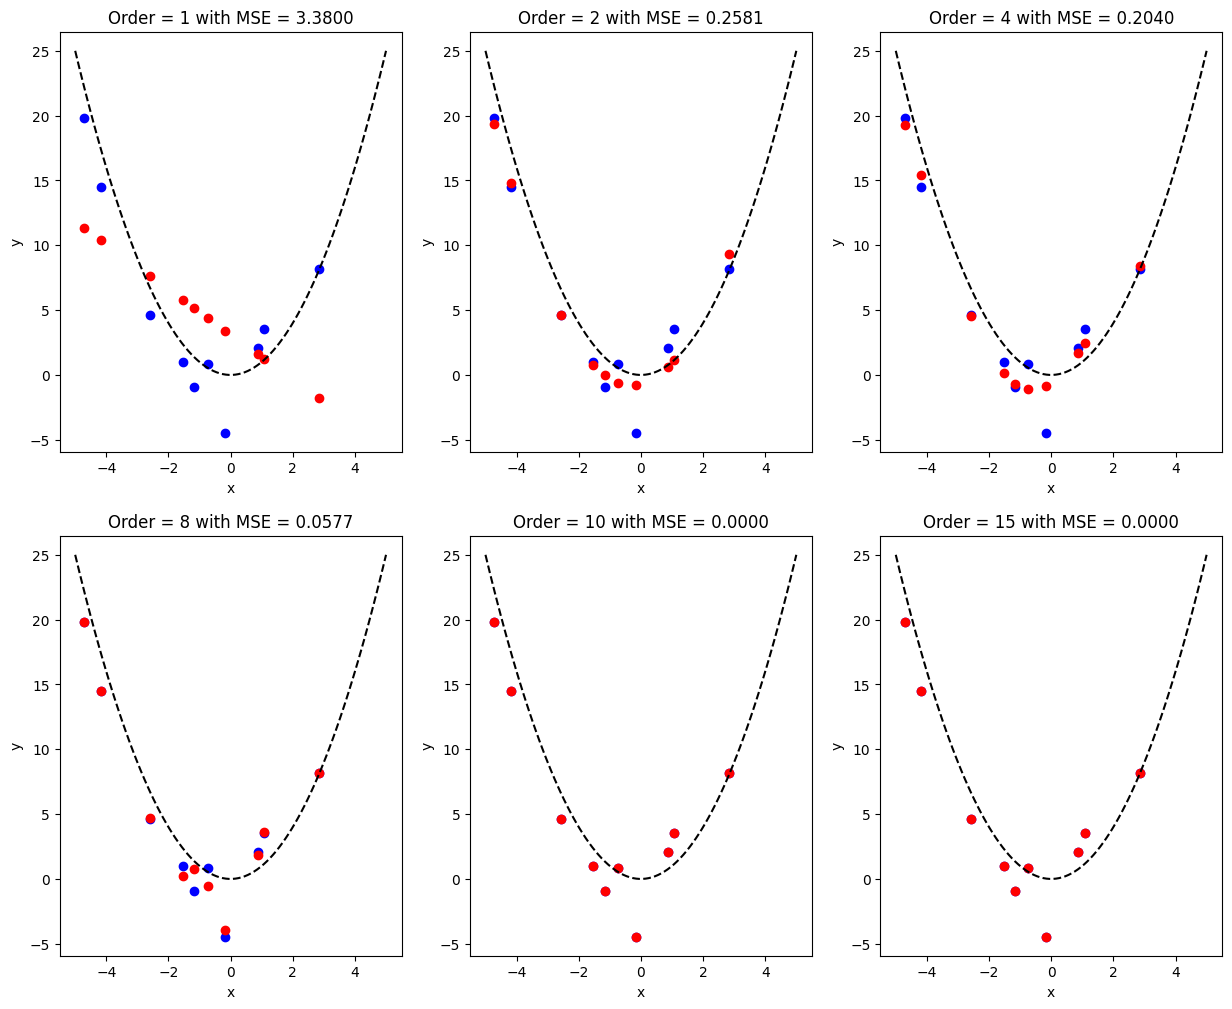

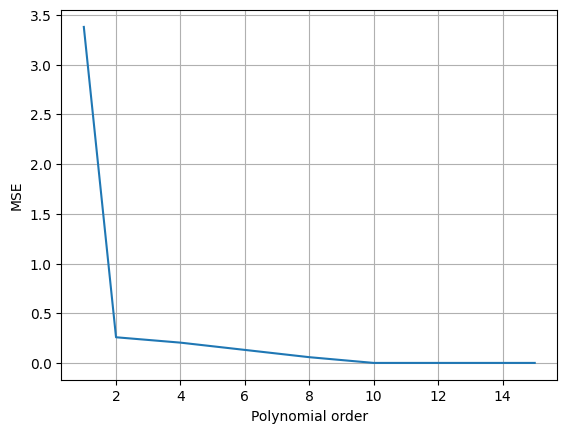

In [12]:
# ลองทดสอบเปลี่ยนค่า polynomial order
poly_order_list = [1,2,4,8,10,15]
mse_list = [] # ตัวแปรสำหรับเก็บค่า mse

fig, ax = plt.subplots(2,3, figsize=(15, 12))
fig_row, fig_col = 0,0

for idx, curr_poly_order in enumerate(poly_order_list):

  # fit โมเดล และให้โมเดลทำนายค่า y ออกมา
  curr_outputs = fit_and_predict_polynomial(x_train, y_train, curr_poly_order)

  # ดึงเอา output ของฟังก์ชันออกมา
  out_x = curr_outputs[0] # ค่า x ที่ถูกใช้ทดสอบโมเดล
  out_y_hat = curr_outputs[1] # ค่า y ที่โมเดลทำนายออกมา
  mse_dict = curr_outputs[3] # ค่า mse ระหว่างสิ่งที่โมเดลทำนายออกมาและผลเฉลย

  # เก็บค่า mse ของแต่ละชุดข้อมูลที่นำมาทดสอบที่มีค่า order ของ polynomial ที่แตกต่างกัน
  mse_list.append(mse_dict['train'])

  # แสดงผล
  if idx % 3 == 0 and idx != 0:
    fig_col = 0
    fig_row += 1

  # Plot ข้อมูลที่เราใช้ fit โมเดล (สอนโมเดล)
  ax[fig_row,fig_col].scatter(x_train, y_train, c='b', label='Observed')

  # Plot ข้อมูลที่โมเดลทำนายค่าออกมา
  ax[fig_row,fig_col].scatter(out_x['train'], out_y_hat['train'], c='r', label='Predicted (poly)')

  # Plot ข้อมูลที่ไม่มี noise สำหรับเป็น reference ไว้ดู
  ax[fig_row,fig_col].plot(x_whole_line, y_true_whole_line, 'k--', label='True')

  ax[fig_row,fig_col].set(xlabel='x', ylabel='y')
  ax[fig_row,fig_col].set_title(f"Order = {curr_poly_order} with MSE = {mse_dict['train']:0.4f}")

  fig_col += 1

# แสดงผล mse vs poly order
plt.figure()
plt.plot(poly_order_list, mse_list)
plt.xlabel('Polynomial order')
plt.ylabel('MSE')
plt.grid()

จากผลการทดสอบเปลี่ยนค่า polynomial order ของโมเดล จะพบว่าค่า MSE ที่ถูกทดสอบมีค่าน้อยลงเรื่อยๆ จนเหลือ $0$ ที่ polynomial order $= 15$

แสดงว่าในการใช้งานจริงเราควรจะใช้ค่า order สูงๆ เนื่องจากมีค่า MSE น้อยที่สุดใช่หรือไม่

---

คำตอบคือไม่

MSE ที่เรานำมาใช้คำนวณเป็น MSE จาก training data ซึ่งเป็นข้อมูลที่โมเดลใช้ในการหาค่า $\hat{w}$ ซึ่งการที่โมเดลมีค่า MSE ต่ำมากๆ แสดงว่าโมเดลมีความสามารถในการ fit ข้อมูลที่โมเดลเคยเห็นมาแล้วได้เป็นอย่างดี แต่ถ้าเกิดว่าเรานำเอาค่า $x$ ตัวใหม่ที่โมเดลไม่เคยเห็นมาก่อน โมเดลที่มี order สูงจะยัง fit ได้ดีหรือไม่

เราจะลองเขียนโปรแกรมเพื่อทดสอบดู

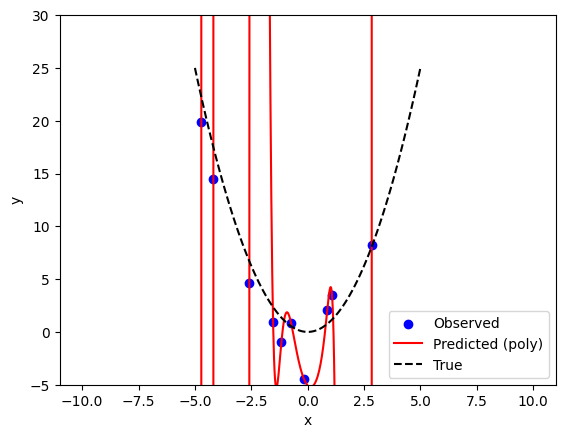

[w_0, w_1, ...]= [ 5.35342883e-06 -2.29690634e+00  8.76527988e+00  1.55708704e-01
  2.56214136e+00  2.84249822e+00 -1.07406744e+00  3.03740734e+00
 -1.61838900e+00  2.92827512e-01  5.24170711e-01 -2.94652008e+00
 -1.37832022e+00  2.06629883e-01  1.64670446e-01  1.85953983e-02]


In [13]:
# สร้างข้อมูลสำหรับใช้ทดสอบจำนวนมาก
x_test = np.reshape(np.linspace(-10,10,1000), (-1,1))
y_test = generate_sample_poly(x_test, w, include_noise=True)

# จากการทดลองด้านบน เราพบว่า poly_order = 15 มีค่า MSE ที่ต่ำที่สุด
poly_order = 15

# fit โมเดล และให้โมเดลทำนายค่า y ออกมา
curr_outputs = fit_and_predict_polynomial(x_train, y_train, curr_poly_order, {'test': x_test}, {'test': y_test})

# ดึงเอา output ของฟังก์ชันออกมา
out_x = curr_outputs[0] # ค่า x ที่ถูกใช้ทดสอบโมเดล
out_y_hat = curr_outputs[1] # ค่า y ที่โมเดลทำนายออกมา
mse_dict = curr_outputs[3] # ค่า mse ระหว่างสิ่งที่โมเดลทำนายออกมาและผลเฉลย
model_coeffs = curr_outputs[4] # ค่า coefficients ของโมเดล

# แสดงผลการทำนาย
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, c='b', label='Observed')
ax.plot(out_x['test'], out_y_hat['test'], c='r', label='Predicted (poly)')
ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True')
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.set_ylim(-5,30)
plt.show()

# แสดงค่า w ของโมเดล
print(f"[w_0, w_1, ...]= {model_coeffs}")

จากการทดสอบด้านบนจะพบว่าโมเดลมี training error เป็นศูนย์ (สังเกตได้จากการที่เส้นสีแดงวิ่งผ่านจุดสีน้ำเงินทั้งหมด) แต่จะเห็นได้ว่าเส้นสีแดงนั้น ไม่สอดคล้องกับ โมเดลจริง (เส้นประสีดำ) เลย

ปัญหาที่โมเดลสามารถให้คำตอบที่ถูกต้องบน training data แต่มีปัญหาในการใช้งานกับข้อมูลที่ไม่ได้ถูกนำมาสอนนั้น มีชื่อเรียกว่าปัญหา overfitting

นอกจากปัญหา overfitting แล้ว เราก็ยังมี underfitting ซึ่งเป็นปัญหาที่เราจะเจอในกรณีที่โมเดลอาจจะมีความซับซ้อนน้อยเกินไป จนไม่สามารถเรียนรู้ที่จะให้คำตอบที่ถูกต้องแม้กระทั่งกับ training data ซึ่งเป็นสิ่งที่ใช้สอนโมเดล

<br><br>
Code ส่วนถัดไปสร้างภาพสรุป concept นี้

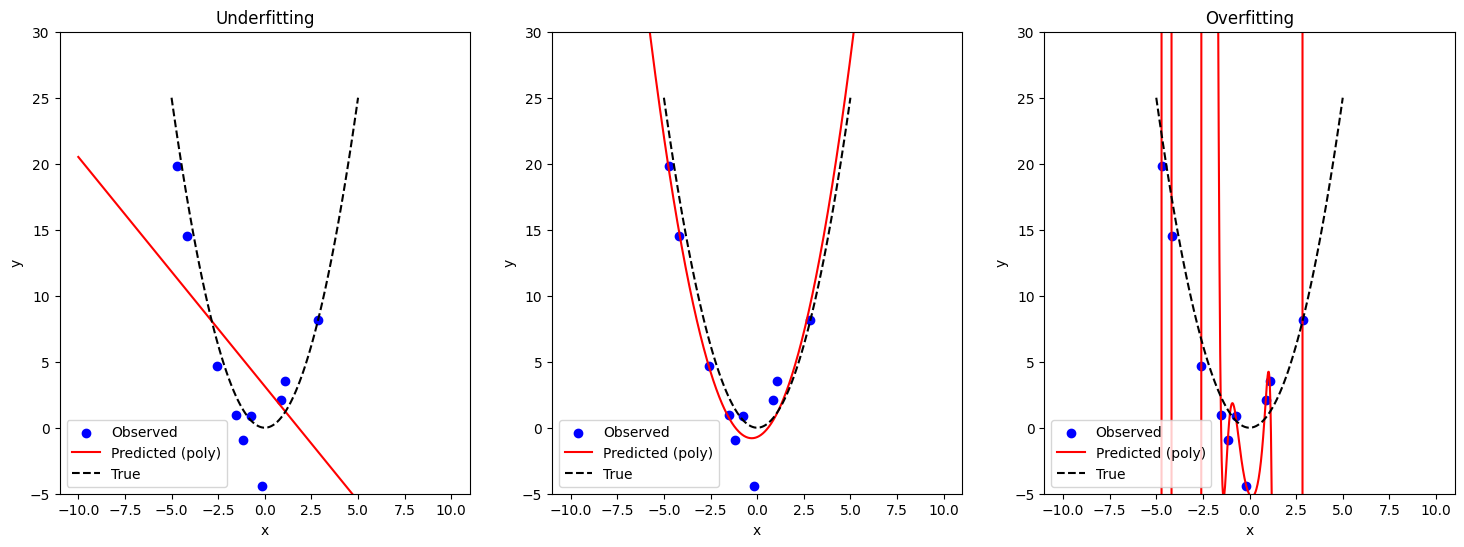

In [14]:
# สร้างข้อมูลสำหรับใช้ทดสอบจำนวนมาก
x_test = np.reshape(np.linspace(-10,10,1000), (-1,1))
y_test = generate_sample_poly(x_test, w, include_noise=True)

# Underfit
curr_outputs = fit_and_predict_polynomial(x_train, y_train, 1, {'test': x_test}, {'test': y_test})
x_test_underfit = curr_outputs[0]['test']
y_hat_test_underfit = curr_outputs[1]['test']

# Well fit
curr_outputs = fit_and_predict_polynomial(x_train, y_train, 2, {'test': x_test}, {'test': y_test})
x_test_wellfit = curr_outputs[0]['test']
y_hat_test_wellfit = curr_outputs[1]['test']

# Overfit
curr_outputs = fit_and_predict_polynomial(x_train, y_train, 15, {'test': x_test}, {'test': y_test})
x_test_overfit = curr_outputs[0]['test']
y_hat_test_overfit = curr_outputs[1]['test']

# แสดงผลการทำนาย
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].scatter(x_train, y_train, c='b', label='Observed')
ax[0].plot(x_test_underfit, y_hat_test_underfit, c='r', label='Predicted (poly)')
ax[0].plot(x_whole_line, y_true_whole_line,'k--', label='True')
ax[0].set(xlabel='x', ylabel='y')
ax[0].legend()
ax[0].set_ylim(-5,30)
ax[0].set_title('Underfitting')

ax[1].scatter(x_train, y_train, c='b', label='Observed')
ax[1].plot(x_test_wellfit, y_hat_test_wellfit, c='r', label='Predicted (poly)')
ax[1].plot(x_whole_line, y_true_whole_line, 'k--', label='True')
ax[1].set(xlabel='x', ylabel='y')
ax[1].legend()
ax[1].set_ylim(-5,30)

ax[2].scatter(x_train, y_train, c='b', label='Observed')
ax[2].plot(x_test_overfit, y_hat_test_overfit, c='r', label='Predicted (poly)')
ax[2].plot(x_whole_line, y_true_whole_line, 'k--', label='True')
ax[2].set(xlabel='x', ylabel='y')
ax[2].legend()
ax[2].set_ylim(-5,30)
ax[2].set_title('Overfitting')

plt.show()

ในกรณีที่เราเจอปัญหา underfitting วิธีแก้ปัญหาวิธีหนึ่งที่ได้รับความนิยมมากก็คือ การเลือกใช้โมเดลที่ซับซ้อนมากยิ่งขึ้น เช่น การเพิ่มจำนวนตัวแปรในโมเดล หรือในตัวอย่างนี้ก็คือการเพิ่ม order ของ polynomial

ในกรณีที่เราเจอปัญญา overfitting เรามีวิธีบรรเทาปัญหานี้หลายวิธี เช่น

1.   การลดจำนวนตัวแปรในโมเดล (สำหรับ polynomial ก็คือการลด order)
2.   การใช้เทคนิค regularization








Regularization
---

ที่ผ่านมา เราหาค่า $\hat{w}$ ที่เหมาะสมในโมเดล polynomial regression โดยการหาค่าต่ำสุดของ loss function ที่วัดความแตกต่างระหว่างค่าที่โมเดลทำนายออกมา ($\hat{y_i}$) และค่าที่เรา observed มา ($y_i$) โดยการคำนวณ mean-squared error หรือ

$$L(y, \hat{y})
= MSE(y,\hat{y})
=\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-\hat{y_i}\right)^{2}
=\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_p} x_i^p)\right)^{2}$$

ซึ่งเราใช้ `PolynomialFeatures` ร่วมกับ `LinearRegression` ของ `scikit-learn` ในการหาค่า $\hat{w}$ เหล่านั้น

จากตัวอย่างที่เรากำหนดให้ $p=15$ ซึ่งเป็น polynomial ที่มี order = 15 หรือมีตัวแปรทั้งหมด 16 ตัว ($\hat{w_0}, \hat{w_1}, ..., \hat{w_{15}}$) เราพบปัญหา overfitting

ในตัวอย่างนี้เราจะลองใช้เทคนิค regularization ทดลองดูว่าเราจะสามารถบรรเทาปัญหา overfitting ที่พบเจอได้หรือไม่

<br><br>

ในรูปแบบมาตรฐานของการใช้เทคนิค regularization เราจะเปลี่ยนหน้าตาของ loss function ไปจากเดิม โดยการเพิ่มพจน์ (term) เข้าไป เช่น การเปลี่ยน loss function ไปเป็น $L(y, \hat{y}) =\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_{15}} x_i^{15})\right)^{2} +λ R(W)$

ในที่นี้เราใช้ $W$ เพื่ออ้างอิงถึง $\hat{w_0}, \hat{w_1}, ..., \hat{w_{15}}$ พร้อมกัน

เราเรียก $R(W)$ ว่าเป็น regularization term ซึ่ง regularization ที่เราจะเห็นได้บ่อยที่สุด ประกอบด้วย


*   $R(W)=\|W\|^2_2 = \hat{w_0}^2 + \hat{w_1}^2 + ... + \hat{w_{15}}^2$ ซึ่งมีชื่อเรียกว่า L2 regularization หรือ Tikhonov regularization

*   $R(W)=\|W\|_1 = |\hat{w_0}| + |\hat{w_1}| + ... + |\hat{w_{15}}|$ หรือ L1 regularization

<br><br>
ถ้าหากเราเพิ่ม L2 regularization term เข้าไป จะส่งผลให้โจทย์ที่เราต้องแก้เปลี่ยนหน้าตาไปเป็น


$\min_{\hat{W}}\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_{15}} x_i^{15})\right)^{2} +λ  (\hat{w_0}^2 + \hat{w_1}^2 + ... + \hat{w_{15}}^2)$

ซึ่งเราเรียกว่า Ridge regression

ในการหาค่าต่ำสุดของฟังก์ชันอันใหม่นี้ เราต้องการให้ทั้ง term ที่ 1 และ term ที่ 2 มีค่าที่ต่ำ

โดยที่มี $λ \ge 0$ เป็นตัวเลขที่ใช้ balance ว่า เราจะให้ความสำคัญกับ  term ที่ 1 หรือ term ที่ 2 มากกว่ากัน

<br><br>
ถ้าหากเราเพิ่ม L1 regularization term เข้าไป โจทย์ของเราจะเปลี่ยนไปเป็น

$\min_{\hat{W}}\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_{15}} x_i^{15})\right)^{2} +λ  (\hat{|w_0|} + \hat{|w_1|} + ... + \hat{|w_{15}}|)$

ซึ่งเราจะเรียกว่า Least Absolute Shrinkage and Selection Operator (LASSO) โดยเราสามารถใช้ $λ\ge0$ เป็นตัวกำหนดความสำคัญของแต่ละ term ได้เช่นกัน


---

**ตัวอย่าง**
สมมติเราใช้ L2 regularization โจทย์ของเราก็คือ

$$\min_{\hat{w}}\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_{15}} x^{15})\right)^{2} +λ  (\hat{w_0}^2 + \hat{w_1}^2 + ... + \hat{w_{15}}^2)$$

เรามาลองพิจารณาหลายๆ กรณีสุดโต่ง 2 กรณี


1.   หากกำหนดให้ $λ=0$ โจทย์ของเราจะกลายเป็น

    $$\min_{\hat{w}}\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-(\hat{w_0} + \hat{w_1}x_i + \hat{w_2} x_i^2 + ... + \hat{w_{15}} x^{15})\right)^{2} + 0 $$
    เราจะได้ loss function ที่ไม่สนใจ regularization term หรือ term ที่ 2 เลย (ก็คือการแก้ปัญหาแบบไม่ใช้ regularization นั่นเอง)

2.   หากกำหนดให้ $λ=10^{10}$ ซึ่งมีค่าที่สูงมากๆ จะเห็นว่า term ที่ 2 จะมีน้ำหนักมากกว่า term ที่ 1 มาก ซึ่งจะส่งผลให้เกิดคำตอบ $\hat{W}$ ที่มีค่าน้อย จนแทบจะมีค่าเป็น $0$ เพื่อให้พจน์ที่สอง มีค่าน้อยที่สุดเท่าที่เป็นไปได้ (ก็คือการแก้ปัญหาแบบแทบจะไม่ได้สนใจ term ที่ 1 เลย)

ในทางปฏิบัติเราจะเลือกค่า $λ$ ที่เป็นจุดสมดุลที่ดีระหว่างทั้ง 2 terms

เรามาลองใช้เทคนิค regularization กัน โดยการคัดลอกฟังก์ชัน `fit_and_predict_polynomial` มาปรับแก้แค่บรรทัดเดียว โดยการเปลี่ยนจะการเรียกใช้ `sklearn.linear_model.LinearRegression` ไปเป็น `sklearn.linear_model.Ridge`


In [15]:
from sklearn.linear_model import Ridge

# ฟังก์ชันสำหรับ fit โมเดล polynomial ที่มี order ที่กำหนด โดยใช้ L2 regularization และ ทำนายผลของโมเดลหลังจากถูกสอนด้วย training data แล้ว
def fit_and_predict_polynomial_ridge(x_train, # ค่า x ที่ใช้เป็น input ของโมเดล (จาก training data)
                                     y_train, # ค่า y ที่ใช้เป็นเฉลยให้โมเดล (จาก training data)
                                     poly_order=4, # ค่า order ของ polynomial ที่เราใช้
                                     lambda_val = 0, # ค่า lambda ที่ใช้ balance ระหว่าง loss function เก่า (term ที่ 1) กับ regularization term (term ที่ 2)
                                     x_test_dict=None, # Python dictionary ที่ใช้เก็บชุดข้อมูลที่เราอยากจะนำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้
                                     y_test_dict=None): # Python dictionary ที่ใช้เก็บชุดข้อมูลที่ค่า y ที่เป็นเฉลยของข้อมูลที่นำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้

  # สร้างตัวแปรประเภท Python dictionary สำหรับเก็บค่า output ของฟังก์ชันนี้
  mse_dict = {} # ค่า mse
  out_x = {} # ค่า x ที่ใช้เป็น input ของโมเดล
  out_y_hat = {} # ค่า y ที่โมเดลตอบมา
  out_y = {} # ค่า y ที่เป็นเฉลย

  # สร้างโมเดลสำหรับแปลงจาก x เป็น z
  extract_poly_feat = PolynomialFeatures(degree=poly_order, include_bias=True)

  # แปลงจากค่า x ให้กลายเป็น z
  z_train = extract_poly_feat.fit_transform(x_train)

  ########### เราจะแก้แค่บรรทัดนี้โดยเปลี่ยนจาก LinearRegression มาเป็น Ridge() ###########
  # สร้างโมเดล y = w_0 + w_1*z + w_2 * z^2 + ... ที่มี L2 regularization
  model_poly = Ridge(alpha=lambda_val*x_train.shape[0])

  # สอนโมเดลจาก training data ที่ input ถูก transfrom จาก x มาเป็น z แล้ว
  model_poly.fit(z_train, y_train)

  # ทดสอบโมเดลบน training data
  y_hat_train = model_poly.predict(z_train)

  # ถ้าเกิดว่า user ไม่ได้ให้ test data มา จะใช้ training data เป็น test data
  if x_test_dict is None:
    x_test_dict = {}
    y_test_dict = {}

  # เพิ่ม training data เข้าไปใน test_dict เพื่อที่จะใช้เป็นหนึ่งในข้อมูลสำหรับที่จะให้โมเดลลองทำนาย
  x_test_dict['train'] = x_train
  y_test_dict['train'] = y_train

  # ทดสอบโมเดลบนข้อมูลแต่ละชุดข้อมูล (แต่ละชุดข้อมูลถูกเลือกจาก key ของ dictionary)
  for curr_mode in x_test_dict.keys():

    # แปลงค่า x ให้เป็น z เหมือนขั้นตอนด้านบนที่เรา fit โมเดล
    z_test = extract_poly_feat.fit_transform(x_test_dict[curr_mode])

    # ทำนายค่า y โดยใช้โมเดล
    y_hat_test = model_poly.predict(z_test)

    # คำนวณค่า mse บน test data
    mse_dict[curr_mode] = mse(y_test_dict[curr_mode], y_hat_test)

    # เตรียมข้อมูลเป็น output ของฟังก์ชันนี้ เผื่อเรียกใช้ภายหลัง เช่น การนำเอาข้อมูลไป plot
    out_x[curr_mode] = x_test_dict[curr_mode] # เก็บค่า x ที่นำมาทดสอบ
    out_y_hat[curr_mode] = y_hat_test # เก็บค่า y ที่โมเดลทำนายออกมา
    out_y[curr_mode] = y_test_dict[curr_mode] # เก็บค่า y ที่เป็นผลเฉลย

  return out_x, out_y_hat, out_y, mse_dict, model_poly.coef_[0]


ทดลอง fit โมเดล polynomial ที่มี order = 15 (ซึ่งเป็นโมเดลที่มีปัญหา overfitting) โดยใช้ $λ$ ค่าต่างๆ

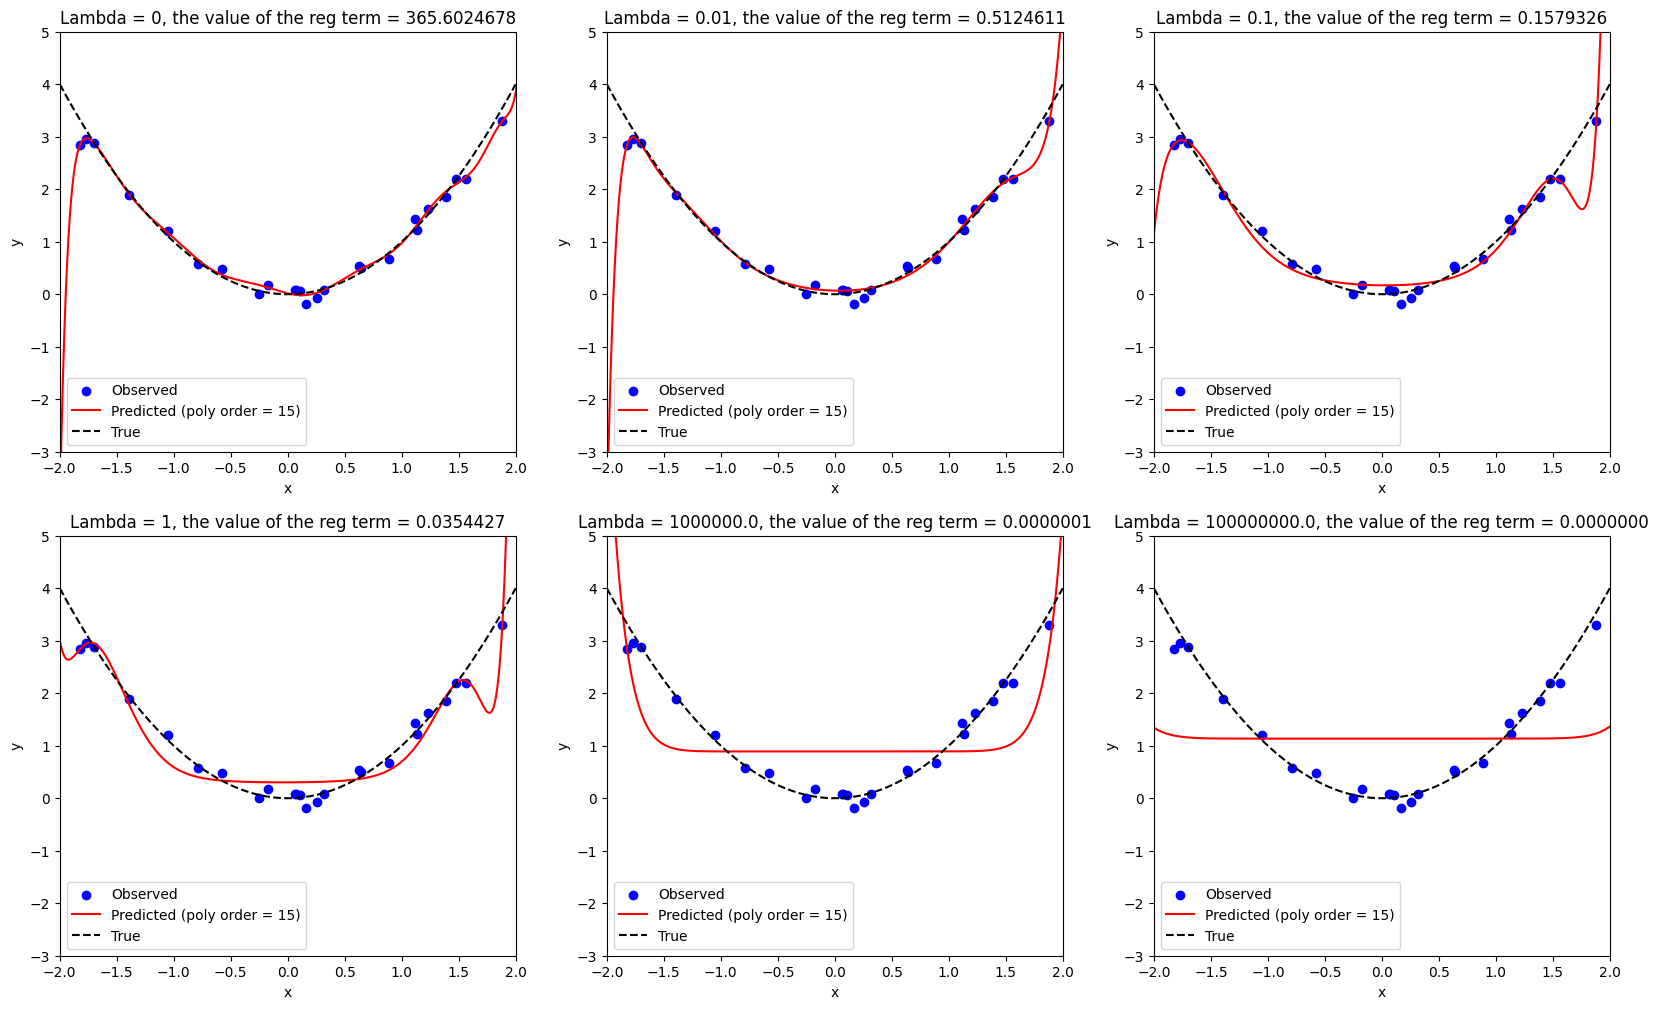

In [16]:
# มีจำนวนข้อมูลแค่ 25 จุด
num_samples = 25
w = [0, 0, 1] # กำหนดให้สมการที่ถูกต้องคือ y = x^2

# สุ่มข้อมูลมาสำหรับใช้ fit โมเดล
x_train = 4*np.random.rand(num_samples,1) - 2
y_train = generate_sample_poly(x_train, w, include_noise=True, noise_level=0.2)

# สร้างข้อมูลที่ไม่มีสัญญาณรบกวนมาเปรียบเทียบ
x_whole_line = np.linspace(-2,2,100)
y_true_whole_line = generate_sample_poly(x_whole_line, w, include_noise=False)

# สร้างข้อมูลสำหรับใช้ทดสอบ
x_test = np.reshape(np.linspace(-3,3,1000), (-1,1))
y_test = generate_sample_poly(x_test, w, include_noise=True)

# ทดลองปรับค่า lambda ดู
lambda_list = [0, 1e-2, 1e-1, 1, 1e6, 1e8]

# กำหนดให้ใช้ polynomial ที่มี order = 15
poly_order = 15

fig, ax = plt.subplots(2, 3, figsize=(20,12))
fig_row, fig_col = 0,0

for idx, curr_lambda in enumerate(lambda_list):

  # fit โมเดล ที่มี L2 regularization และให้โมเดลทำนายค่า y ออกมา
  if curr_lambda == 0:

    # ถ้าไม่มี regularization จะเรียกใช้ฟังก์ชันเดิม
    curr_outputs = fit_and_predict_polynomial(x_train,
                                              y_train,
                                              poly_order,
                                              {'test': x_test},
                                              {'test': y_test})
  else:
    # ถ้ามี regularization จะใช้ฟังก์ชันใหม่
    curr_outputs = fit_and_predict_polynomial_ridge(x_train,
                                                    y_train,
                                                    poly_order,
                                                    curr_lambda,
                                                    {'test': x_test},
                                                    {'test': y_test})

  x_test = curr_outputs[0]['test']
  y_hat_test = curr_outputs[1]['test']
  term2_val = norm(curr_outputs[4],ord=2)**(2) # Compute the squared L2 norm of the model's coefficients

  # แสดงผลการทำนาย
  if idx % 3 == 0 and idx != 0:
    fig_col = 0
    fig_row += 1

  ax[fig_row, fig_col].scatter(x_train, y_train, c='b', label='Observed')
  ax[fig_row, fig_col].plot(x_test, y_hat_test, c='r', label='Predicted (poly order = 15)')
  ax[fig_row, fig_col].plot(x_whole_line, y_true_whole_line,'k--', label='True')
  ax[fig_row, fig_col].set(xlabel='x', ylabel='y')
  ax[fig_row, fig_col].legend()
  ax[fig_row, fig_col].set_ylim(-3,5)
  ax[fig_row, fig_col].set_xlim(-2,2)
  ax[fig_row, fig_col].set_title(f"Lambda = {curr_lambda}, the value of the reg term = {term2_val:0.7f}")

  fig_col += 1
plt.show()

จากการทดสอบด้านบน สังเกตได้ว่า


*   ถ้ากำหนดให้ $λ=0$ จะทำให้เกิดปัญหา overfitting โดยสิ่งที่โมเดลทำนาย จะ fit กับ training data (จุดสีน้ำเงิน) ได้ค่อนข้างดี ในขณะที่โมเดลไม่สามารถทำนายในบริเวณที่อยู่นอก training data ได้อย่างแม่นยำ สังเกตได้จากเส้นสีแดงมีค่าที่เปลี่ยนไปอย่างรวดเร็ว (แกว่งไปมา) และมีหน้าตาที่แตกต่างจากความสัมพันธ์ที่แท้จริง (เส้นประสีดำ) เป็นอย่างมาก

*   การกำหนดให้ค่า $λ=0.01$ ส่งผลให้เส้นสีแดงแกว่งตัวน้อยลง และ fit กับความสัมพันธ์ที่แท้จริง (เส้นประสีดำ) มากขึ้นกว่าเดิม


*   การเพิ่มค่า $λ$ ให้สูงขึ้นไปเรื่อยๆ จะส่งผลให้โมเดลให้ความสนใจในการลดค่าของ regularization term มากยิ่งขึ้นเรื่อยๆ แสดงให้เห็นจากค่า $\hat{w_0}^2 + \hat{w_1}^2 + ... + \hat{w_{15}}^2$ ที่ลดลงเรื่อยๆ

*   การที่โมเดลให้ความสนใจในการลดค่าของ regularization term ไปเรื่อยๆ (จากการเพิ่มค่า $λ$) จะส่งผลให้โมเดลสนใจที่จะ fit กับ training data (จุดสีน้ำเงิน) น้อยลงเรื่อยๆ ทำให้ได้ผลลัพธ์เป็นโมเดลที่มีหน้าตาแตกต่างจากทั้งข้อมูลที่เก็บมา (สีน้ำเงิน) และความสัมพันธ์ที่แท้จริง (เส้นประสีดำ)

จากตัวอย่างนี้ จะเห็นได้ว่า การใช้ regularization โดยที่ปรับค่า $λ$ ได้อย่างเหมาะสม สามารถช่วยบรรเทาปัญหา overfitting ได้ในระดับหนึ่ง ซึ่งในปัจจุบัน ได้มีการคิดค้น regularization term ต่างๆ ขึ้นมามากมาย โดยที่แต่ละตัวที่คิดค้นมา ก็มีความเหมาะสมกับโจทย์ที่แตกต่างกัน ในสถานการณ์ที่แตกต่างกัน


